In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

In [4]:
# MNIST
def mnist(batch_sz, valid_size=0.2, shuffle=True, random_seed=2000):
    num_classes = 10
    transform_train = transforms.Compose([
                        transforms.RandomCrop(28, padding=4),
                        transforms.ToTensor(),
                    ])
    
    transform_valid = transforms.Compose([
                        transforms.ToTensor(),
                    ])
    
    transform_test = transforms.Compose([
                        transforms.ToTensor(),
                    ])
    

    # Training dataset
    train_data = MNIST(root='./datasets', train=True, download=True, transform=transform_train)
    valid_data = MNIST(root='./datasets', train=True, download=True, transform=transform_valid)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    if shuffle == True:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_sz, sampler=train_sampler,pin_memory=True)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_sz, sampler=valid_sampler,pin_memory=True)

    # Test dataset
    test_data = MNIST(root='./datasets', train=False, download=True, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_sz, shuffle=False, pin_memory=True)

    return train_loader, valid_loader, test_loader



In [5]:
batch_sz=64 # this is batch size i.e. the number of rows in a batch of data
train_loader, valid_loader, test_loader=mnist(batch_sz) 

<class 'torchvision.datasets.mnist.MNIST'>


In [7]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,20,5,1)
        self.conv2 = nn.Conv2d(20,50,5,1)
        self.l1 = nn.Linear(4*4*50,100)
        self.l2 = nn.Linear(100,10)

    def forward(self, x):
        # (28,20)
        x = self.conv1(x)
        # (24,24)
        x = F.relu(x)
        x = F.max_pool2d(x, (2,2))
        # (12,12)
        x = self.conv2(x)
        # (8,8)
        x = F.relu(x)
        x = F.max_pool2d(x, (2,2))
        # (4,4)
        x = x.view(-1,4*4*50)
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        return x

In [10]:
writer = SummaryWriter("runs/lr_1")

device = torch.device('cuda:0')
net = ConvNet()
net = net.to(device)
lr = 0.1
momentum = 0.0
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, verbose=True)


ls=[]
for i in range(5):
  loss_total=0
  loss_val=0
  acc_train=0
  total_train=0
  for ii,batch in enumerate(train_loader):
    data=batch[0]
    label=batch[1]
    #optimizer-->buffer += grad
    optimizer.zero_grad()
    data, label = data.to(device), label.to(device)
    logits = net(data)
    #this is the output of the network and it's shape is batch_size X no of classes
    loss = F.cross_entropy(logits, label)
    loss_total+=loss.item()

    loss.backward()
    optimizer.step()
    
    out=torch.argmax(logits, dim=1)
    acc_train+=torch.sum(out==label)
    total_train+=logits.shape[0]

  acc_val=0
  total_val=0 
  with torch.no_grad():
    for jj,batch in enumerate(valid_loader):
          data=batch[0]
          label=batch[1]
          #optimizer-->buffer += grad
          data, label = data.to(device), label.to(device)
          logits = net(data)
          print(logits.shape)
          print(label.shape)
          break
          loss = F.cross_entropy(logits, label)
          loss_val+=loss.item()
          out=torch.argmax(logits, dim=1)
          acc_val+=torch.sum(out==label)
          total_val+=logits.shape[0]



  ls.append(loss_total)
  lr_scheduler.step()
  print(f"Iterataion {i}: Training Loss: {loss_total/ii}, Validation Loss: {loss_val/jj}")
  print(f"Iteataion {i}: Training Accuracy: {acc_train.item()/total_train}, Validation Accuracy  {acc_val.item()/total_val}")
  writer.add_scalar('Loss/train', loss_total/ii, i)
  writer.add_scalar('Loss/test', loss_val/jj, i)
  writer.add_scalar('Accuracy/train', acc_train.item()/total_train, i)
  writer.add_scalar('Accuracy/test', acc_val.item()/total_val, i)
plt.plot(ls)

Adjusting learning rate of group 0 to 1.0000e-01.
torch.Size([64, 10])
torch.Size([64])
Adjusting learning rate of group 0 to 9.0000e-02.


ZeroDivisionError: division by zero

In [11]:
acc_val=0
total_val=0 
with torch.no_grad():
      for jj,batch in enumerate(valid_loader):
            data=batch[0]
            label=batch[1]
            #optimizer-->buffer += grad
            data, label = data.to(device), label.to(device)
            logits = net(data)
            loss = F.cross_entropy(logits, label)
            loss_val+=loss.item()
            out=torch.argmax(logits, dim=1)
            acc_val+=torch.sum(out==label)
            total_val+=logits.shape[0]

print(f"Testing Accuracy: {acc_val.item()/total_val}")

Testing Accuracy: 0.9855


In [ ]:
#Q1: define a 2 layer simple NN for mnist digit classificaiton

In [ ]:
#Q2: Define a CNN with 2 conv layer and 2 linear layers for mnist digit communication

In [ ]:
#Q3: Train both networks for 10 epochs and compare their performance 

In [ ]:
#Q4: Compare the accuarcay of both networks on the test set

In [ ]:
#Q5: go through the testset and plot some samples of incorrect results

In [ ]:
#Q6: show the output of the intermediate layers

In [ ]:
#Q7: Compare the time of training on CPU and GPU

torch.Size([5, 1, 28, 28])
tensor(0)


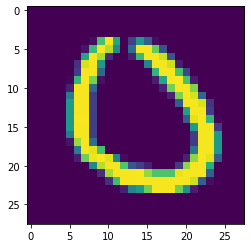

In [ ]:


for i,batch in enumerate(train_loader):
  if i>0:
    break


  x=batch[0]
  y=batch[1]

  print(x.shape)
  plt.imshow(x[3,0,:,:])
  print(y[3])  